<a href="https://colab.research.google.com/github/visiont3lab/webot-epuck-line-follower-camera/blob/main/LineDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [3]:
# OPencv
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


(array([[[858,  18]],

       [[857,  19]],

       [[851,  19]],

       ...,

       [[878,  19]],

       [[873,  19]],

       [[872,  18]]], dtype=int32),)
{'m00': 272327.5, 'm10': 222692702.16666666, 'm01': 172693085.5, 'm20': 184116141525.5833, 'm11': 136403274203.95833, 'm02': 140627838747.5833, 'm30': 153814738188395.84, 'm21': 108955082923978.31, 'm12': 108908595390727.61, 'm03': 127809387450567.45, 'mu20': 2011728279.4304504, 'mu11': -4814523688.264084, 'mu02': 31116673773.387497, 'mu30': -34268915093.53125, 'mu21': 74173023811.23706, 'mu12': 17926954086.941406, 'mu03': -832502146932.0469, 'nu20': 0.027126035298778065, 'nu11': -0.06491877697898106, 'nu02': 0.41957554595615665, 'nu30': -0.0008854654242627141, 'nu21': 0.0019165371246393215, 'nu12': 0.00046320982041617533, 'nu03': -0.021510802566141154}


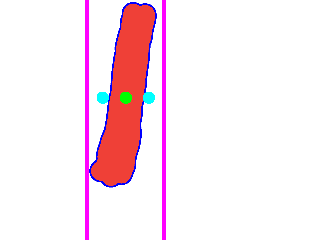

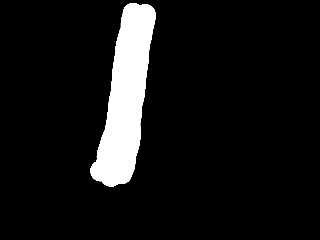

In [76]:
import cv2
from PIL import Image
import numpy as np 

im = cv2.imread("color.png", cv2.IMREAD_COLOR) #BGR
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#im = cv2.imread("photo.jpg", cv2.IMREAD_GRAYSCALE)

#print(im.shape)
#print( np.unique(im) )
# Bianco e nero

gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
w, h = gray.shape
ret, thresh = cv2.threshold(gray, 127,255, cv2.THRESH_BINARY_INV)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(contours)
cv2.drawContours(im, contours, -1, (0,0,255), 10 )

if len(contours)>0:
  c = contours[0]
  M = cv2.moments(c)
  print(M)
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  cv2.circle(im, (cX,cY), 40, (0,255,0),-1)
  cv2.circle(im, (cX+150,cY), 40, (0,255,255),-1)
  cv2.circle(im, (cX-150,cY), 40, (0,255,255),-1)
  cv2.line(im, (cX-250,0), (cX-250,h), (255,0,255), 25)
  cv2.line(im, (cX+250,0), (cX+250,h), (255,0,255), 25)
        

# 0 - 255
imt = cv2.resize(thresh, (320,240))
im = cv2.resize(im, (320,240))

display(Image.fromarray(im))
display(Image.fromarray(imt))